#Sentiment analysis for tweets

@Ilkan Esiyok - 13 Apr 2016

<b>TIMING STARTS</b>

In [1]:
import time
start_time = time.time() 

In [ ]:
TRAIN_DATA_FILE_PATH = 'C:\\Users\\iesiyok\\Desktop\\LMS\\Web.Search\\Assg1\\Assignment1_data\\train.json'
DEV_DATA_FILE_PATH = 'C:\\Users\\iesiyok\\Desktop\\LMS\\Web.Search\\Assg1\\Assignment1_data\\dev.json'
TEST_DATA_FILE_PATH = 'C:\\Users\\iesiyok\\Desktop\\LMS\\Web.Search\\Assg1\\Assignment1_data\\test.json'

In [2]:
from __future__ import division
%matplotlib inline
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import words
import json
import nltk
import numpy as np
import itertools
from nltk.tokenize.regexp import WordPunctTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from scipy import sparse
from random import randrange
from nltk.corpus import brown
import math
import operator
import gensim 
from nltk.data import find
import operator
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.corpus import opinion_lexicon
from collections import Counter

<b>HELPER METHODS</b>

Includes the methods which are required for preprocessing. The explanations are given for each method on top of their definition.

In [3]:
class Helper:
    
    corpus = None
    
    def __init__(self, corpus):
        self.corpus = corpus
    
    #lemmatization only used in max_match method
    def lemmatize(self, word):
        lemmatizer = WordNetLemmatizer()
        lemma = lemmatizer.lemmatize(word,'v')
        if lemma == word:
            lemma = lemmatizer.lemmatize(word,'n')
        return lemma


    #max_match method is used in order to process hashtags
    def max_match_applier(self, hashtag):
        hashtag = hashtag.group().lstrip('#')
        return self.max_match(hashtag)

    #max_match method, basically works as :
    #moving through words from last character to first character and stopping when a word matches-> a word in the corpus
    def max_match(self, hashtag):
        #you should convert it to a python set before you use it TODO

        sentence = re.split(r'(\d+)', hashtag)#split with the numbers, (if there is)
        word_list = ''
        for word in sentence:
            if word.isdigit():
                word_list += word + ' '
            else:
                length = len(word)
                i = 0
                while i < length :
                    for j in range(length, i, -1):
                        ht = word[i : j]
                        if(self.lemmatize(ht.lower()) in corpus):#lower operation here doesn't change the original letter
                            word_list += ht + ' '
                            i = j-1
                            break
                    i+=1

        return word_list.rstrip()

    #removes hashtags in the text
    def remove_hashtags(self, sentence):
        regexp = r'(^|\W)#(\w+)'
        return re.sub(regexp, self.max_match_applier, sentence)    

    #tokenizes the words in sentences
    def word_tokenizer(self, sentence, wordpunct_tokenizer):
        return wordpunct_tokenizer.tokenize(sentence)

    #splits text into sentences
    def sent_segmenter(self, tweet, sent_segmenter):   
        return sent_segmenter.tokenize(tweet)

    #removes user names from the text
    def remove_usernames(self, tweet):
        regexp = r'(^|\W)@(\w+)'
        return re.sub(regexp, '', tweet, flags=re.IGNORECASE)   

    #improvement method - removes user names from the text
    def remove_usernames_imp(self, tweet):
        regexp = r'(^|\W)@(\w+)'
        return re.sub(regexp, ' ', tweet, flags=re.IGNORECASE)

    #removes urls from text
    def remove_urls(self, tweet):
        regexp = r'(^|\W)(http|https)://.+?($|\s)'
        return re.sub(regexp, '', tweet, flags=re.IGNORECASE)

    #improvement method - removes urls from text
    def remove_urls_imp(self, tweet):
        regexp = r'(^|\W)(http|https)://.+?($|\s)'
        return re.sub(regexp, ' ', tweet, flags=re.IGNORECASE)

    #improvement method - this method only removes . and , characters from the text
    def remove_punct_imp(self, tweet):
        regexp = r'[\.,]'
        return re.sub(regexp, ' ', tweet, flags=re.IGNORECASE)

    #lower case
    def lower_case(self, tweet):
        return tweet.lower()

    #remove stop words in text
    def remove_stop_words(self, tweet, stop_words_set, f_dict):
        for word in tweet:    
            if word not in stop_words_set:
                f_dict.append(word)
        return f_dict  

    #improvement method - removes numbers in text, except ones which are joined with letters like '25th'
    def remove_numbers_imp(self, tweet):
        regexp = r'(^|\b).[0-9]+(\b|$)'
        return re.sub(regexp, ' ', tweet, flags=re.IGNORECASE)

    #improvement method - removes multiple spaces in text
    def remove_spaces_imp(self, tweet):
        regexp = r'  +'
        return re.sub(regexp, ' ', tweet, flags=re.IGNORECASE)

    #improvement method - removes single punctiations in the text, except ! and ? which might be informative in sentiment analysis context
    def remove_spec_puncts_imp(self, tweet):
        #! and ? might be informative, so we won't remove them
        regexp = r'(^|\s)\(|\)|\[|\]|\{|\}|\*|&|@|-|\\|\/|=|\+|:|;|<|>|_|\^|%|\$|#|(\s|$)'
        return re.sub(regexp, ' ', tweet, flags=re.IGNORECASE)

    #improvement method - removes words which are like letters in the text : example 'm', 'a'
    def remove_single_words_imp(self, tweet):
        regexp = r'(^|\b)[a-zA-Z0-9](\b|$)'
        return re.sub(regexp, ' ', tweet, flags=re.IGNORECASE)

    #returns the frequency of words in text
    def get_BOW(self, text):
        BOW = {}
        for word in text:
            BOW[word] = BOW.get(word,0) + 1
        return BOW

    #removes words that appear less than n times in whole text
    def remove_less_than_n_times(self, BOW_list, n):
        temp_dict = sum((Counter(x) for x in BOW_list ), Counter())      
        return BOW_list
    

In [4]:
#the corpus helps us to identify if the word is in the corpus
corpus = set(words.words())
helper = Helper(corpus)#cretes an instance from Helper class

<b>PREPROCESSING</b>

Includes preprocessing methods and works with helper methods above.

In [6]:
#tokenizes the words in sentence
wordpunct_tokenizer = WordPunctTokenizer()
#splits text into sentences
sent_segmenter = nltk.data.load('tokenizers/punkt/english.pickle')
#stop_words corpus
stop_words_set = set(stopwords.words())
#vectorizer, helps to create sparse matrixes
vectorizer = DictVectorizer() 

class Pre_Processor:

    helper = None
    
    def __init__(self, helper):
        self.helper = helper
    
    #original preprocess method
    def preprocess(self, tweet):
        tweet = helper.remove_urls(tweet)
        tweet = helper.remove_usernames(tweet)
        tweet = helper.remove_hashtags(tweet)
        tweet = helper.lower_case(tweet)
        sentences = helper.sent_segmenter(tweet, sent_segmenter)
        words_list = []
        for sentence in sentences:#we may have multiple sentences
            words_list.append(helper.word_tokenizer(sentence, wordpunct_tokenizer))

        return words_list

    #improved preprocess method
    def preprocess_improvement(self, tweet):
        tweet = helper.remove_urls_imp(tweet)
        tweet = helper.remove_usernames_imp(tweet)
        tweet = helper.remove_hashtags(tweet)
        tweet = helper.lower_case(tweet)

        sentences = helper.sent_segmenter(tweet, sent_segmenter)

        words_list = []
        for sentence in sentences:#we may have multiple sentences
            sentence = helper.remove_punct_imp(sentence)
            #sentence = helper.max_match(sentence)
            sentence = helper.remove_numbers_imp(sentence)
            sentence = helper.remove_single_words_imp(sentence)
            sentence = helper.remove_spec_puncts_imp(sentence)
            sentence = helper.remove_spaces_imp(sentence)
            words_list.append(helper.word_tokenizer(sentence, wordpunct_tokenizer))

        return words_list

    #original preprocess_file, gets the file and returns tweets, classes and dictionary
    def preprocess_file(self, filename):

        tweets =[] 
        labels = []
        word_dict = {}
        f = open(filename)
        for line in f:
            tweet_dict = json.loads(line)
            words_list = self.preprocess(tweet_dict['text'])
            tweets.append(words_list)
            labels.append(int(tweet_dict["label"]))
            for words in words_list:
                for word in words:
                    word_dict[word] = word_dict.get(word,0) + 1

        return tweets, labels, word_dict

    #improved preprocess_file, gets the file and returns tweets, classes and dictionary  
    #calls preprocess_improvement method,
    def preprocess_file_improvement(self, filename):

        tweets =[] 
        labels = []
        word_dict = {}
        f = open(filename)
        for line in f:
            tweet_dict = json.loads(line)
            words_list = self.preprocess_improvement(tweet_dict['text'])
            tweets.append(words_list)
            labels.append(int(tweet_dict["label"]))
            for words in words_list:
                for word in words:
                    word_dict[word] = word_dict.get(word,0) + 1

        return tweets, labels, word_dict

    #creates feature dictionaries from tweets
    #if remove_stop_words is True : it removes stop words from text
    #if n is the number of minimum frquency of a word in whole file, if n =0 this control isn't applied 
    def convert_to_feature_dicts(self, tweets, remove_stop_words, n, wordDict):
        feature_dicts = []

        for tweet in tweets:
            long_sentence = list(itertools.chain(*tweet))
            if remove_stop_words:
                for word in long_sentence:
                    if word in stop_words_set:
                        long_sentence.remove(word)
                    else:
                        if n > 0 and int(wordDict[word]) < n :
                            long_sentence.remove(word)
            else:
                if n > 0 and wordDict[word] < n:
                            long_sentence.remove(word)

            BOW = helper.get_BOW(long_sentence)
            feature_dicts.append(BOW)

        return feature_dicts

    #classifiers uses this method to get predictions, accuracy_score and report
    def classifying(self, classifier, data, labels ):

        predictions = classifier.predict(data)
        print accuracy_score(labels, predictions)  
        print classification_report(labels, predictions) 
        

        
    #applies grid search to a classsifier and finds out best parameters
    def tuning(self, classifier, parameters, dev_data, dev_labels):
        import matplotlib.pyplot as plt
        fig = plt.figure()
        
        
        gs = GridSearchCV(classifier, parameters, n_jobs=1)
        gs.fit(dev_data, dev_labels)
        #print gs.grid_scores_ 
        print 'Best score: ' + str(gs.best_score_)#finds the best score according to the params
        best_parameters = gs.best_estimator_.get_params()
        print 'Parameters : '
        for p_name in sorted(parameters.keys()):
            print("  %s: %r" % (p_name, best_parameters[p_name]))
        
        y = []
        x = []
        #gs.grid_scores_ contains every possiblity
        for param_s, mean_score, _ in gs.grid_scores_: 
#             print "%0.4f for %r" % (mean_score, param_s)
            y.append(mean_score)
            x.append(param_s)
#reference for bar chart : 
#http://stackoverflow.com/questions/11617719/how-to-plot-a-very-simple-bar-chart-python-matplotlib-using-input-txt-file
        N = len(y)
        width = 0.45
        indice = np.arange(len(y))
        plt.bar(indice, y, width=width)
        plt.xticks(indice + width / 2, x)

        fig.autofmt_xdate()#for showing x axis better
        plt.show()
        
        #predictions = gs.predict(test_data)
        #print classification_report(test_labels, predictions)    



In [7]:
pre_processing = Pre_Processor(helper)#creates an instance from Pre_Processor class

<b>PRE - PROCESSING STARTS</b>

We will call preprocessing block and send the data file paths.

In [8]:
#training data preprocessing
train_tweets, train_labels, train_word_dict = pre_processing.preprocess_file(TRAIN_DATA_FILE_PATH)
#converting tweets to list of vector dictionaries
train_feature_dicts = pre_processing.convert_to_feature_dicts(train_tweets, True, 2, train_word_dict) 
#creating sparse matrix from dictionaries
train_sparse = vectorizer.fit_transform(train_feature_dicts).toarray()

In [9]:
#dev data preprocessing -- same process except we don't remove stop-words and words which are less than n
dev_tweets, dev_labels, dev_word_dict = pre_processing.preprocess_file(DEV_DATA_FILE_PATH)
dev_feature_dicts = pre_processing.convert_to_feature_dicts(dev_tweets, False, 0, dev_word_dict)
dev_sparse = vectorizer.transform(dev_feature_dicts)

<b>TUNING AND CLASSIFYING</b>

We will train both DecisonTreeClassifier and LogisticRegressionClassifier, and will try to identify best available parameters for the best classifications.

In [10]:
#decision tree classifier
time1 = time.time()
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_sparse, train_labels)
pre_processing.classifying(dt_classifier, dev_sparse, dev_labels)
print("--- DT Classification time : %s seconds ---" % (time.time() - time1))


0.428649535265
             precision    recall  f1-score   support

         -1       0.29      0.25      0.27       360
          0       0.42      0.56      0.48       700
          1       0.52      0.40      0.45       769

avg / total       0.44      0.43      0.42      1829

--- DT Classification time : 137.391000032 seconds ---


Best score: 0.453253143794
Parameters : 
  max_depth: 13
  max_features: 'auto'
  random_state: 28


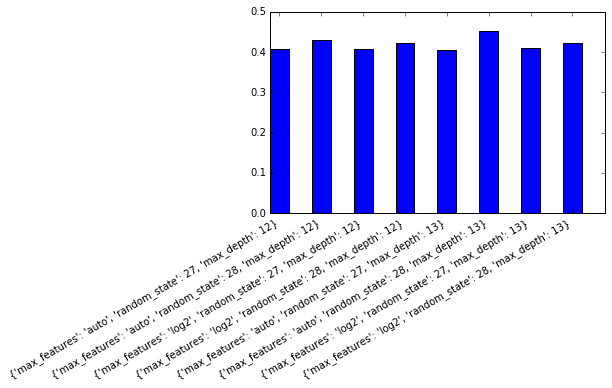

In [11]:
#dec_tree_parameters = {'max_depth':np.arange(10,99),'max_features':['auto', 'sqrt', 'log2',None, np.arange(0.01,0.99)],'class_weight':['balanced',{1:0.5,-1:0.3, 0:0.2 }, None]}
#tuning process for decision tree
dec_tree_parameters = {'max_depth':np.arange(12,14),'max_features':['auto', 'log2'],'random_state':np.arange(27,29)}
pre_processing.tuning(dt_classifier, dec_tree_parameters, dev_sparse, dev_labels)

<b>Comment:</b>
Overfitting occurs when a classifier runs better on some data, but runs bad on others. That is because the classifier overlearns from its training data. In the process of tuning we are running the model with different parameter values on the same data set in order to find best parameter suite. However, since we are running on the same data set this parameter suite, this parameter suite might be good for this data set, but it might be very bad for different data set( the data set that the model have never seen)(i.e the parameter suite might overfit to the development set). In order to determine this situation we can perform cross-validation on the data set in order to evaluate model's performance with the best parameter values on unseen data.

In [12]:
#logistic regression classifier
time1 = time.time()
log_reg_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial')
log_reg_classifier.fit(train_sparse, train_labels)
pre_processing.classifying(log_reg_classifier, dev_sparse, dev_labels)
print("--- LR Classification time : %s seconds ---" % (time.time() - time1))

0.481683980317
             precision    recall  f1-score   support

         -1       0.34      0.34      0.34       360
          0       0.44      0.64      0.52       700
          1       0.71      0.40      0.52       769

avg / total       0.53      0.48      0.48      1829

--- LR Classification time : 97.9670000076 seconds ---


Best score: 0.457627118644
Parameters : 
  C: 0.01
  random_state: 0
  solver: 'newton-cg'


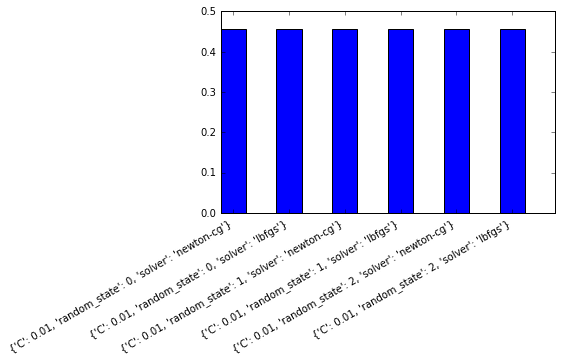

In [13]:
#logistic regression tuning
log_reg_parameters = { 'C':np.arange(0.01, 0.03), 'random_state':np.arange(0, 3), 'solver':['newton-cg', 'lbfgs']}
pre_processing.tuning(LogisticRegression(multi_class='multinomial'), log_reg_parameters, dev_sparse, dev_labels)

<b>Comment</b>
Since we have to use multi_class:'multinominal', there are two options available for solver method, which are 'newton-cg' and 'lbfgs'. Although, both methods result into the same accuracy score, the execution time for 'newton-cg' method is reasonably less than 'lbfgs' method.


<b>Comment</b>
Our accuracies for two classifiers are below 50% which means none of the classifiers could fit to the development set, despite the fact that we have a huge number of features(#15423). Also, DecisionTree classifier takes much longer time to train than LogisticRegression classifier. This is a challenging task in terms of performance, because the classifier each time tries a different parameter and value, the model has to be retrained each time and the training task is the most expensive task in terms of performance.

<b>MY LOGISTIC REGRESSION</b>

Logistic Regression class from scratch, [only predict and predict proba methods]
Initialization parameters are taken from the builtin LogisticRegression classifier which we trained above.

In [14]:
#definition of MyLogisticRegression class, it imitates the builtin LogisticRegression class
class MyLogisticRegression:
    
    #initializes parameters
    def __init__(self, weights, constants, labels):
        self.weights = weights #coefs
        self.constants = constants #intercepts
        self.labels = labels #classes

    #predicts the probability of each class according to the formula
    def predict_proba(self, X):
        
        result = []
        for row in X:

            dotProdNeg = np.exp(np.add(np.dot(row.toarray(),self.weights[0]),self.constants[0]))[0]
            dotProdNeut = np.exp(np.add(np.dot(row.toarray(),self.weights[1]),self.constants[1]))[0]
            dotProdPos = np.exp(np.add(np.dot(row.toarray(),self.weights[2]),self.constants[2]))[0]
            Z = dotProdNeg + dotProdNeut + dotProdPos
            
            dotProdNeg = dotProdNeg/Z;
            dotProdNeut = dotProdNeut/Z;
            dotProdPos = dotProdPos/Z;
            
            result.append([dotProdNeg,dotProdNeut,dotProdPos])
            
        return result;  
        
    #finds the label
    def label(self,y):
        return self.labels[y]
    
    #calculates the probabilities and returns the labels corresponding to the maximum probability
    def predict(self, X):

        Z = self.predict_proba(X)
        sig = []
        for row in Z:
            dotProdNeg = 1 / (1 + np.exp(-1 * row[0]))
            dotProdNeut = 1 / (1 + np.exp(-1 * row[1]))
            dotProdPos = 1 / (1 + np.exp(-1 * row[2]))
            sig.append([dotProdNeg, dotProdNeut, dotProdPos])    
        #finds the labels of maxi-probabilities
        labels=map(self.label, np.argmax(sig, axis=1))
        
        return labels

In [15]:
#the definition of class is above
my_clf = MyLogisticRegression(log_reg_classifier.coef_, log_reg_classifier.intercept_, log_reg_classifier.classes_)
#creating 5 sample data from development set to test if the classifier creates same results
sample_data = dev_sparse[0:5]
my_predict = my_clf.predict(sample_data)
my_predict_proba = my_clf.predict_proba(sample_data)

log_reg_predict = log_reg_classifier.predict(sample_data)
log_reg_predict_proba = log_reg_classifier.predict_proba(sample_data)

Classifier Comparison:

In [16]:
#show that my classifier's predict_proba method creates the same probablities with built-in log. regression
#(may have little calc. differences so I used np.allclose method)
if np.allclose(np.asarray(my_predict_proba), np.asarray(log_reg_predict_proba)):
    print 'Predict proba : They are equal'
else:
    print 'Predict proba : They are not equal'

Predict proba : They are equal


In [17]:
#show that my classifier's predict method creates the same labels with built-in log. regression
if np.array_equal(np.asarray(my_predict), np.asarray(log_reg_predict)):
    print 'Predict : They are equal'
else:
    print 'Predict : They are not equal'

Predict : They are equal


<b>POLARITY LEXICON</b>

There are four different lexicons we are going to use. Sentiword_net, Manual Lexicon, Word2vec, Brown corpus with PPMI.

<b>SEEDS</b>

In [18]:
positive_seeds = ["good","nice","excellent","positive","fortunate","correct","superior","great"]
negative_seeds = ["bad","nasty","poor","negative","unfortunate","wrong","inferior","awful"]

<b>MANUAL LEXICON</b>

In [19]:
#manually annotated set
positive_words = opinion_lexicon.positive()
negative_words = opinion_lexicon.negative()

<b>1. SENTIWORD _NET </b>

Sentiword is a lexicon which has polarity scores for words. We are going to use it in this block.
The definitions of the methods are on top of each method. Also, there are explanations for some important operations in the methods. The important method is 'sentiword_net_calc()'. This method returns two lists which are lists of positive and negative words in sysnset. We decide whether a word is positive or negative by looking all of the lemmas of that word and we get the most common polarity score as the result.

In [20]:

class SentiWord_Class:

    #this method compares pos_score and neg_score of synset_name, and with obj_score, then selects the bigger one as polarity type
    def get_polarity_type(self, synset_name):
        swn_synset =  swn.senti_synset(synset_name)#brings synset
        if not swn_synset:
            return None
        elif swn_synset.pos_score() > swn_synset.neg_score() and swn_synset.pos_score() > swn_synset.obj_score():
            return 1
        elif swn_synset.neg_score() > swn_synset.pos_score() and swn_synset.neg_score() > swn_synset.obj_score():
            return -1
        else:
            return 0

    #returns the global resulting positive and negative lists 
    def sentiword_net_calc(self):
        syn_pos_list = []
        syn_neg_list = []
        #move through all synsets
        for synset in wn.all_synsets():
            #select each lemmas in the synsets
            for lemma in synset.lemmas():
                #take lemma_list for each lemma
                lemma_list = list(swn.senti_synsets(str(lemma.name())))
                lemma_dict = {}
                for lem in lemma_list:
                    count = self.get_polarity_type(lem.synset.name())
                    #dictionary collects positive, negative and neutral count of lemmas
                    lemma_dict[count] = lemma_dict.get(count, 0) + 1

                #filter the dictionary according to the number of positive, negative and neutral counts
                key, _ = max(lemma_dict.iteritems(), key=lambda x:x[1])    
                if key == 1:
                    syn_pos_list.append(str(lemma.name()))
                elif key == -1:
                    syn_neg_list.append(str(lemma.name()))

        return syn_pos_list, syn_neg_list

In [21]:
sentiword_net = SentiWord_Class()#creates an instance from SentiWord_Class

In [22]:
#import sentiword_net

syn_pos_list = []#the list of positive words in synset
syn_neg_list = []#the list of negative words in synset
#syn_pos_list, syn_neg_list = sentiword_net.sentiword_net_calc()
syn_pos_list, syn_neg_list = sentiword_net.sentiword_net_calc()

In [23]:
#this block takes 5 random value from syn_pos_list and compares the results with positive words list of manual annotated set
i = 0
while(i<5):
    i += 1
    random_index = randrange(0,len(syn_pos_list))
    print ('\''+syn_pos_list[random_index]+'\'' , syn_pos_list[random_index] in set(positive_words))
    

("'boffo'", False)
("'trustfulness'", False)
("'lasciviousness'", False)
("'free-spoken'", False)
("'reenlistment'", False)


In [24]:
#this block takes 5 random value from syn_neg_list and compares the results with negative words list of manual annotated set
i = 0
while(i<5):
    i += 1
    random_index = randrange(0,len(syn_neg_list))
    print ('\''+syn_neg_list[random_index]+'\'' , syn_neg_list[random_index] in set(negative_words))
     

("'flub'", False)
("'Pythium_debaryanum'", False)
("'scrofulous'", False)
("'thankless'", True)
("'laxity'", False)


<b>Comment:</b>
Note that FALSE results only show that the word is not included in the manually annotated lexicon.
By intuition the words "confirmable, neat and hearty" look positive words and the lexicon identified them as positive, thefore it is correct. However since they are not in the manually annotated lexicon the result was False for them. Because, the size of the manually annotated set is very small. Since the lexicon finds the most common polarity among the lemmas of the words, that may help to better identification.

<b>2. COSINE SIMILARITY</b>

This block includes the Cosine similarity. We will calculate cosine similarity between our seeds above and the words in gensim vovabulary.

In [25]:

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.Word2Vec.load_word2vec_format(word2vec_sample, binary=False)

class CosSimilarity_Class:

    def cos_similarity(self, positive_seeds, negative_seeds):

        #calculating cosine similarity between our seeds and the words in gensim vocabulary, creates matrixes
        pos = cosine_similarity(model[positive_seeds], model[model.vocab.keys()])
        neg = -1 * cosine_similarity(model[negative_seeds], model[model.vocab.keys()])

        #creating matrixes' transposes, because we need a matrix showing cos distances of each word in the vocab to each seed words
        #for example the transpose of pos matrix will create a 8 rows and len(vocab) columns matrix
        pos = pos.T 
        neg = neg.T

        total_cs = pos + neg

        all_words = np.asarray(model.vocab.keys())
        #finding the average of value in the matrix
        total_cs_avg = np.average(total_cs, axis = 1)

        #filtering the words according to the total average and creating pos and neg words lists
        pos_words = all_words[np.where(total_cs_avg>0.03)[0]]
        pos_words_score = total_cs_avg[np.where(total_cs_avg>0.03)[0]]

        neg_words = all_words[np.where(total_cs_avg<-0.03)[0]]
        neg_words_score = total_cs_avg[np.where(total_cs_avg<-0.03)[0]]

        return pos_words, pos_words_score, neg_words, neg_words_score
    

In [26]:
cosine_sim = CosSimilarity_Class()#creates an instance from CosSimilarity_Class

In [27]:
cs_pos_list, cs_pos_words_score, cs_neg_list, cs_neg_words_score = cosine_sim.cos_similarity(positive_seeds, negative_seeds)

In [28]:
#this block takes 5 random value from cs_pos_list and compares the results with positive words list of manual annotated set

i = 0
while(i<5):
    i += 1
    random_index = randrange(0,len(cs_pos_list))
    print ('\''+cs_pos_list[random_index]+'\'', cs_pos_list[random_index] in set(positive_words))


(u"'champion'", True)
(u"'reconnaissance'", False)
(u"'toasted'", False)
(u"'undying'", False)
(u"'strategic'", False)


In [29]:
#this block takes 5 random value from cs_neg_list and compares the results with negative words list of manual annotated set
i = 0
while(i<5):
    i += 1
    random_index = randrange(0,len(cs_neg_list))
    print ('\''+cs_neg_list[random_index]+'\'' , cs_neg_list[random_index] in set(negative_words))
    

(u"'unfertilized'", False)
(u"'rubbed'", False)
(u"'numbing'", False)
(u"'beards'", False)
(u"'Policies'", False)


<b>Comment:</b>
It identifies the positive words like 'complement', 'imaginative' as positive and negative words like 'scream' as negative. Some of the words such as 'deport' classified as negative, however they intuitively look like neutral. 

In [30]:
#creates dictionaries of pos and neg words to increase performance
cs_pos_dict = dict(zip(cs_pos_list, cs_pos_words_score))
cs_neg_dict = dict(zip(cs_neg_list, cs_neg_words_score))

<b>3. PPMI</b>

This block contains calculating PPMI with the help of Brown corpus. The blok consists of:
preprocessing step, 
creating pmi matrix step, 
calculating total and 
finding average(filtering) step. THere are definitions on top of each methods and explanations for important code blocks.

In [31]:

class PPMI_Class:
    
    def init():
        pass
    
    #preprocessing of PPMI
    def prep_ppmi(self, pos_set, neg_set):
        #finding the frequency of each word in brown corpus, but counting only once in each file
        word_freq = {}
        files = brown.fileids()
        length = len(files)
        for i in range(length):
            cur_file_words = brown.words(files[i])
            for j in range(len(cur_file_words)):
                    word_freq[str(files[i]) + '_' + cur_file_words[j]] = 1  #count only once since it is binary

        #calculating frequency
        word_freq_n = {}
        for word in word_freq:
        #     pdb.set_trace()
            word = re.sub(r'.+_', '', word, flags=re.IGNORECASE)
            word_freq_n[word] = word_freq_n.get(word, 0) + 1

        word_freq = word_freq_n #we put every single word counts into dictionary word_freq

        #co-ocurrence
        #finds each word combinations appearing together in a file
        #this process doesn't get in sentence level(like 'good idea' appearing together), it worksin file level
        #namely it is enough for us to consider the two words have cooccurence if they appear in the same text, (no location concern) 
        word_freq_co = {}
        files = brown.fileids()
        length = len(files)
        for i in range(length):
            cur_file_words = brown.words(files[i])
            #pdb.set_trace()
            for j in range(len(cur_file_words)):
                if (cur_file_words[j] in pos_set or cur_file_words[j] in neg_set):
                    for doc_word in cur_file_words:
                        #we are adding the file_id to the front in order to escape from duplicates
                        word_freq_co[str(files[i]) + '_' + cur_file_words[j] + '-' + doc_word ] = 1

        #calculating frequencies of cooccurences
        word_freq_con = {}
        for collocation in word_freq_co:
            collocation = re.sub(r'.+_', '', collocation, flags=re.IGNORECASE)
            word_freq_con[collocation] = word_freq_con.get(collocation, 0) + 1

        return word_freq, word_freq_con


    #creating the matrixes for representing ppmi results of positive seeds and words in brown corpus 
    def create_pmi_matrix(self, word_freq, word_freq_con, positive_seeds, negative_seeds):
        pmi_matrix_pos = []
        total_count = len(brown.words());
        for seed in positive_seeds:
            row = []
            for word in word_freq:
                both_count = word_freq_con.get(seed + '-' + word, 0)
                word1_count = word_freq.get(seed, 0);
                word2_count = word_freq.get(word, 0);

                ppmi = math.log((both_count/total_count)/((word1_count/total_count)*(word2_count/total_count)), 2) if both_count!=0 else 0
                #ppmi doesn't get negative results
                row.append( ppmi if  ppmi > 0 else 0)
            pmi_matrix_pos.append(row);

        #creating the matrixes for representing ppmi results of negative seeds and words in brown corpus    
        pmi_matrix_neg = []
        for seed in negative_seeds:
            row = []
            for word in word_freq:
                both_count = word_freq_con.get(seed + '-' + word, 0)
                word1_count = word_freq.get(seed, 0);
                word2_count = word_freq.get(word, 0);

                ppmi = math.log((both_count/total_count)/((word1_count/total_count)*(word2_count/total_count)), 2)  if both_count!=0 else 0
                #ppmi doesn't get negative results
                row.append( ppmi if  ppmi > 0 else 0)
                #row.append( math.log((both_count/total_count)/((word1_count/total_count)*(word2_count/total_count)), 2) if both_count!=0 else 0)
            pmi_matrix_neg.append(row);

        return pmi_matrix_pos, pmi_matrix_neg


    #creating matrixes' transposes, because we need a matrix showing ppmi of each word in the vocab to each seed words
    #for example the transpose of pmi_pos matrix will create a 8 rows and len(vocab) columns matrix
    def create_total_avg_matrix(self, pmi_matrix_pos, pmi_matrix_neg):
        pmi_matrix_pos = np.asarray(pmi_matrix_pos).T
        pmi_matrix_neg = (-1*np.asarray( pmi_matrix_neg)).T
        total = pmi_matrix_pos + pmi_matrix_neg
        #then we get the total and average
        total_avg = np.average(total,axis = 1)
        # pmi_matrix_avg_pos = np.average(pmi_matrix_pos,axis=1)
        # pmi_matrix_avg_neg = np.average(pmi_matrix_neg,axis=1)
        return total_avg

    #filtering the words according to the total average and creating pos and neg words lists    
    def filter(self, word_freq, total_avg):

        words =  np.asarray(word_freq.keys())
        pmi_positive_words = words[np.where(total_avg>0.03)[0]]
        pos_words_score = total_avg[np.where(total_avg>0.03)[0]]

        #the formula below could be used to get most importants, @@TODO
        # pos_dict = sorted(pos_dict.items(), key=operator.itemgetter(1),reverse=True)

        pmi_negative_words = words[np.where(total_avg<-0.03)[0]]
        neg_words_score = total_avg[np.where(total_avg<-0.03)[0]]

        # neg_dict = sorted(neg_dict.items(), key=operator.itemgetter(1),reverse=True)

        return pmi_positive_words, pos_words_score, pmi_negative_words, neg_words_score

In [32]:
#put seeds into set for better performance
pos_set = set(positive_seeds)
neg_set = set(negative_seeds)

In [33]:
#import ppmi
ppmi = PPMI_Class()#creates a new instance of PPMI_CLass
word_freq, word_freq_con = ppmi.prep_ppmi(pos_set, neg_set)
pmi_matrix_pos, pmi_matrix_neg = ppmi.create_pmi_matrix(word_freq, word_freq_con, positive_seeds, negative_seeds)
total_avg = ppmi.create_total_avg_matrix(pmi_matrix_pos, pmi_matrix_neg)
pmi_positive_list, pmi_pos_words_score, pmi_negative_list, pmi_neg_words_score = ppmi.filter(word_freq, total_avg)

In [34]:
#this block takes 5 random value from pmi_positive_list and compares the results with positive words list of manual annotated set
i = 0
while(i<5):
    i += 1
    random_index = randrange(0,len(pmi_positive_list))
    print ('\''+pmi_positive_list[random_index]+'\'' , pmi_positive_list[random_index] in set(positive_words))
    

(u"'complicate'", False)
(u"'staging'", False)
(u"'ferret'", False)
(u"'Lavaughn'", False)
(u"'Corp.'", False)


In [35]:
#this block takes 5 random value from pmi_negative_list and compares the results with negative words list of manual annotated set
i = 0
while(i<5):
    i += 1
    random_index = randrange(0,len(pmi_negative_list))
    print ('\''+pmi_negative_list[random_index]+'\'' , pmi_negative_list[random_index] in set(negative_words))
    

(u"'favors'", False)
(u"'defiantly'", True)
(u"'barley'", False)
(u"'platitudinous'", False)
(u"'hotel's'", False)


<b>Comment:</b>
It was really hard to find a word that looks intuitively positive and identified correct in this lexicon. This might be because of the size of documents and words in the brown corpus. A positive word 'gentle' is recognised as positive which is true, however a negative word like 'inaccuracies' identified as positive, which is wrong. Also, many of the neutral words identified as positive or negative. Since we look words appearing in the same text level(not in sentence level), that may not give us valid information about the word's polarity, as polarity can vary in a text.

In [36]:
pmi_pos_dict = dict(zip(pmi_positive_list, pmi_pos_words_score))
pmi_neg_dict = dict(zip(pmi_negative_list, pmi_neg_words_score))

#print len(np.asarray(word_freq.keys())[total_avg<-0.03])

<b>ACCURACY RESULTS OF POLARITY LEXICONS</b>

We are going to use a generic class which is Acc_Calculator as defined below for evaluating the accuracies of the lexicons.

In [37]:

class Acc_Calculator:
    #accuracy calculator method
    def acc_calc(self, pos_list, neg_list, positive_words, negative_words ):

        #filtering automatically produced words 
        syn_neg_words = [s.lower() for s in neg_list]
        #taking automatically produced negative words overlapping with manually annotated set
        syn_neg_words = set(syn_neg_words) & (set(positive_words) | set(negative_words)) #correct neg words

        syn_pos_words = [s.lower() for s in pos_list]
        #taking automatically produced positive words overlapping with manually annotated set
        syn_pos_words = set(syn_pos_words) & (set(positive_words) | set(negative_words)) #correct pos words

        #accuracy result will be the division of correct_results by the all words
        acc = (len(set(syn_neg_words) & set(negative_words) ) + len(set(syn_pos_words) & set(positive_words)))/len(set(syn_neg_words) | set(syn_pos_words))
        return acc, syn_pos_words, syn_neg_words

In [38]:
lex_acc_calc = Acc_Calculator()#creates an instance of Acc_Calculator class

<b>ACCURACY SENTIWORD_NET</b>

In [39]:
acc_senti_word, syn_pos_words, syn_neg_words = lex_acc_calc.acc_calc(syn_pos_list, syn_neg_list, positive_words,negative_words)
print acc_senti_word

0.845197740113


<b>ACCURACY PPMI</b>

In [40]:
acc_pmi, pmi_pos_words, pmi_neg_words = lex_acc_calc.acc_calc(pmi_pos_dict.keys(), pmi_neg_dict.keys(), positive_words, negative_words )
print acc_pmi

0.479035166817


<b>ACCURACY COSINE SIMILARITY</b>

In [41]:
acc_cos_sim, cs_pos_words, cs_neg_words = lex_acc_calc.acc_calc(cs_pos_dict.keys(), cs_neg_dict.keys(), positive_words, negative_words )
print acc_cos_sim

0.967262723521


<b>TESTING AUTOMATICALLY-PRODUCED LEXICONS AGAINST A MANUALLY-ANNOTATED SET</b>

For this task we are going to use the class Lex_Polarity as defined below.

In [42]:

class Lex_Polarity:

    #this method calculates the polar score of a sentence according to one of the three lexicons sent as a parameter
    def calculate_polar_score(self, sentence, lexicon):
        lex_pos_set = lexicon[0]
        lex_neg_set = lexicon[1]

        pos_count = 0
        neg_count = 0
        #moves throgh the words in sentence and finds out if they are in pos_list or neg_list
        for word in sentence:
            if word in lex_pos_set:
                pos_count += 1
            elif word in lex_neg_set:
                neg_count += 1

        #then returns the polar score
        if pos_count > neg_count:
            return 1
        elif pos_count < neg_count:
            return -1
        else:
            return 0

    #this method calculates accuracy of lexicons
    #most common usage is lex_a is one of automatically created lexicons {cs_lex, ppmi_lex, syn_lex} and
    #lex_m is manual lexicon. Since we will test these automatically-produced lexicons against the manually-annotated lexicon
    #also this method typically works on development set
    def get_acc(self, tweets, lex_a, lex_m):
        correct_pred = 0
        for tweet in tweets:
            #itertools.chain(): flattens the tweet, as we have seperated sentences in the tweet
            tweet = itertools.chain(*tweet)
            pred = self.calculate_polar_score(tweet, lex_a)
            act = self.calculate_polar_score(tweet, lex_m)
            if(pred == act):
                correct_pred += 1
        return correct_pred/len(tweets)

    #calculates polarity score in given tweet_set with respect to the given lexicon
    def get_polarity_score(self, lexicon, tweet_set):
        score = []
        for tweet in tweet_set:
            tweet = itertools.chain(*tweet)
            score.append(self.calculate_polar_score(tweet, lexicon))
        return score

    #We will create polarity vectors and will add them into the sparse matrix as new features
    def get_polarity_vectors(self, dev_sparse, tweet_set, cs_lex, ppmi_lex, syn_lex, man_lex):
        #we need to get transposes of vectors, as we need each polarity score for each tweet
        cs_pol_vector = np.asarray(self.get_polarity_score(cs_lex, tweet_set))[np.newaxis].T
        ppmi_pol_vector = np.asarray(self.get_polarity_score(ppmi_lex, tweet_set))[np.newaxis].T
        syn_pol_vector = np.asarray(self.get_polarity_score(syn_lex, tweet_set))[np.newaxis].T
        man_pol_vector = np.asarray(self.get_polarity_score(man_lex, tweet_set))[np.newaxis].T
        dev_sparse2 = dev_sparse.toarray()

        #adding the vectors to sparse matrix
        dev_sparse2 = np.append(dev_sparse2, cs_pol_vector, axis=1)
        dev_sparse2 = np.append(dev_sparse2, ppmi_pol_vector, axis=1)
        dev_sparse2 = np.append(dev_sparse2, syn_pol_vector, axis=1)
        dev_sparse2 = np.append(dev_sparse2, man_pol_vector, axis=1)

        #from scipy import sparse
        dev_sparse = sparse.csr_matrix(dev_sparse2)
        return dev_sparse

    def get_polarity_vectors_imp(self, dev_sparse, tweet_set, cs_lex):
        #we need to get transposes of vectors, as we need each polarity score for each tweet
        cs_pol_vector = np.asarray(self.get_polarity_score(cs_lex, tweet_set))[np.newaxis].T
        dev_sparse2 = dev_sparse.toarray()
        dev_sparse2 = np.append(dev_sparse2, cs_pol_vector, axis=1)
        #from scipy import sparse
        dev_sparse = sparse.csr_matrix(dev_sparse2)
        return dev_sparse

In [43]:
lex_polarity = Lex_Polarity()# creates an instance of Lex_Polarity class

In [44]:
#import lex_polarity

#all lexicons we created so far, represented here as tuples
cs_lex = (set(cs_pos_words), set(cs_neg_words))#cosine sim lexicon
ppmi_lex = (set(pmi_pos_words),set(pmi_neg_words))#ppmi lexicon
syn_lex = (set(syn_pos_words),set(syn_neg_words))#sentiword lexicon
man_lex = (set(positive_words),set(negative_words))#manual lexicon

<b>A small test</b>

In [45]:
#a small test of a polar score method via ppmi lexicon
sentence = "good habit"
sentence = sentence.split()
print lex_polarity.calculate_polar_score(sentence, ppmi_lex)

1


<b>Accuracies</b>

In [46]:
#We are gettting the accuracies against the manually annotated lexicon(man_lex)
cs_lex_accuracy = lex_polarity.get_acc(dev_tweets, cs_lex, man_lex)
ppmi_lex_accuracy = lex_polarity.get_acc(dev_tweets, ppmi_lex, man_lex)
syn_lex_accuracy = lex_polarity.get_acc(dev_tweets, syn_lex, man_lex)

In [47]:
print cs_lex_accuracy

0.476216511755


In [48]:
print ppmi_lex_accuracy

0.358119190815


In [49]:
print syn_lex_accuracy

0.835975943138


<b>Comment:</b>
The results show that Sentiwordnet lexicon is the most successful one. Intuitevely speaking, the word without context can be determined as positive, negative or neutral, by looking at its most common polarity among its lemmas. That makes this lexicon stronger than others. Therefore, sentiword_net lexicon resulted in high accuracy.

<b>ADDING POLARITIES TO THE DATA</b> Includes new "convert_to_feature_dict function"

In [50]:
#creating and adding polarity vectors[all of them] for each training and development datas
new_train_sparse = lex_polarity.get_polarity_vectors(sparse.csr_matrix(train_sparse), train_tweets, cs_lex, ppmi_lex, syn_lex, man_lex)
new_dev_sparse = lex_polarity.get_polarity_vectors(sparse.csr_matrix(dev_sparse), dev_tweets, cs_lex, ppmi_lex, syn_lex, man_lex)

In [51]:
#classifier with the best parameters
log_reg_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=0.01, random_state=0)
#we will train the classifier with the new sparse document, which has the new features we defined and added as vectors above
log_reg_classifier.fit(new_train_sparse, train_labels)
pre_processing.classifying(log_reg_classifier, new_dev_sparse, dev_labels)


0.513395297977
             precision    recall  f1-score   support

         -1       0.42      0.28      0.33       360
          0       0.46      0.68      0.55       700
          1       0.66      0.47      0.55       769

avg / total       0.53      0.51      0.51      1829



<b>Comment:</b>
I added the polarity scores to the training data and development data as new features. However, the accuracy of the classifier did not improve, since, the accuracies of our polarity lexicons were not very high. 

<b>ERROR ANALYSIS AND IMPROVEMENT</b>

In [52]:
#sampling data 80/20

#splitting the training set
#we are finding indices to able to know which data are selected, 
#so we can get the corresponding data in all matrixes such as from train_tweets, train_sparse etc.
train_indices = np.random.rand(new_train_sparse.shape[0]) < 0.8
# test_indices =  np.random.rand(new_train_sparse.shape[0]) > 0.8
test_indices = np.asarray([not x for x in train_indices])

#X_train: training data and y_train:label
X_train = new_train_sparse[train_indices]
y_train = np.asarray(train_labels)[train_indices]

#X_test: test data and y_test:label
X_test = new_train_sparse[test_indices]
y_test = np.asarray(train_labels)[test_indices]

# X_test, y_train, y_test = train_test_split(new_train_sparse, train_labels, test_size=0.20, random_state=42)
log_reg_classifier.fit(X_train, y_train)

#finding predicted probabilities with predict_proba method of the classifier
pred_probas = log_reg_classifier.predict_proba(X_test)
#finding predicted classes with predict method of the classifier
pred_labels = log_reg_classifier.predict(X_test)
#actual classes are the labels in our training set
act_labels = y_test
act_proba = []

#finding actual probalities from act_labels list, with the help of the indices defined above
for i in range(len(act_labels)):
    act_proba.append(pred_probas[i][act_labels[i]+1])

pred_probas  = np.max(pred_probas,axis=1)

#finding the error between pred_probas and act_probas
error = np.asarray(pred_probas) - np.asarray(act_proba)

train_tweets_flatten = [val for tweetList in train_tweets for val in tweetList]

#printing first 30 results, where the probability of the predicted class and the actual class are fairly close (less than 0.2)
error_ind = np.where((error<0.2) & ( error>0))
zip(np.asarray(train_tweets_flatten)[error_ind],pred_probas[error_ind],np.asarray(act_proba)[error_ind],act_labels[error_ind],pred_labels[error_ind])[0:30]


[([u'2nd', u'computer', u'with', u'same', u'error', u'!!'],
  0.50648623157565975,
  0.32756308921587241,
  -1,
  0),
 ([u'hopefully',
   u'it',
   u'works',
   u'out',
   u'for',
   u'dev',
   u'to',
   u'replace',
   u'my',
   u'laptop',
   u'=)'],
  0.45835811663184661,
  0.32819928431754086,
  1,
  0),
 ([u'spent',
   u'over',
   u'40',
   u'mins',
   u'&',
   u'gave',
   u'up',
   u'coz',
   u'it',
   u'changes',
   u'just',
   u'before',
   u'you',
   u'print',
   u'every',
   u'time',
   u'.'],
  0.48199944315755483,
  0.41640652713230353,
  1,
  0),
 ([u'i', u'will', u'be', u'at', u'the', u'race', u'on', u'sun'],
  0.45241036233034393,
  0.38078293676807834,
  1,
  0),
 ([u'you', u"'", u've', u'got', u'a', u'month', u'.'],
  0.3943898562585505,
  0.24524702181480107,
  -1,
  0),
 ([u'2nd', u'try', u'!'], 0.40757539904793399, 0.34411394431622883, -1, 1),
 ([u'on',
   u'hold',
   u'with',
   u'support',
   u'for',
   u'52',
   u'minutes',
   u'now',
   u'.'],
  0.3922612649055801

In [53]:
#err_analyser = Error_Analyser()#creates an instance from Error_Analyser
#print err_analyser.analyse()

In [54]:
# 1.0 * len(error[np.where(error > 0)])/len(error)

<b>IMPROVEMENT</b>|

In [55]:
#taking the data from files(train and dev) again in order to apply the improved preprocess 
impr_train_tweets, impr_train_labels, impr_train_word_dict = pre_processing.preprocess_file_improvement(TRAIN_DATA_FILE_PATH)
impr_train_feature_dicts = pre_processing.convert_to_feature_dicts(impr_train_tweets, True, 2, impr_train_word_dict) 
impr_train_sparse = vectorizer.fit_transform(impr_train_feature_dicts).toarray()

impr_dev_tweets, impr_dev_labels, impr_dev_word_dict = pre_processing.preprocess_file_improvement(DEV_DATA_FILE_PATH)
impr_dev_feature_dicts = pre_processing.convert_to_feature_dicts(impr_dev_tweets, True, 2, impr_dev_word_dict)
impr_dev_sparse = vectorizer.transform(impr_dev_feature_dicts)

In [56]:
#in this case we are adding only sentiword_net lexicon to data, because it has the best accuracy
impr_new_train_sparse = lex_polarity.get_polarity_vectors_imp(sparse.csr_matrix(impr_train_sparse), impr_train_tweets, cs_lex)
impr_new_dev_sparse = lex_polarity.get_polarity_vectors_imp(sparse.csr_matrix(impr_dev_sparse), impr_dev_tweets, cs_lex)

In [57]:
log_reg_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', C=0.01, random_state=0)
#we will retrain the classifier with the new sparse document, which has the new features we defined and added as vectors above
log_reg_classifier.fit(impr_new_train_sparse, impr_train_labels)
pre_processing.classifying(log_reg_classifier, impr_new_dev_sparse, impr_dev_labels)

0.515582285402
             precision    recall  f1-score   support

         -1       0.46      0.14      0.22       360
          0       0.45      0.74      0.56       700
          1       0.66      0.48      0.56       769

avg / total       0.54      0.52      0.49      1829



<b>TESTING</b>

Includes preprocessing, classifying, one of the lexicons(result of Cosine Similarity) and my improvement (which is on preprocessing).

In [58]:
test_tweets, test_labels, test_word_dict = pre_processing.preprocess_file_improvement(TEST_DATA_FILE_PATH)
test_feature_dicts = pre_processing.convert_to_feature_dicts(test_tweets, True, 2, test_word_dict)
test_sparse = vectorizer.transform(test_feature_dicts)

In [59]:
test_sparse = lex_polarity.get_polarity_vectors_imp(sparse.csr_matrix(test_sparse), test_tweets, cs_lex)

In [60]:
pre_processing.classifying(log_reg_classifier, test_sparse, test_labels)

0.520199225235
             precision    recall  f1-score   support

         -1       0.41      0.19      0.26       290
          0       0.43      0.73      0.54       625
          1       0.71      0.48      0.57       892

avg / total       0.56      0.52      0.51      1807



In [61]:
print("--- Total Exec. time : %s seconds ---" % (time.time() - start_time))

--- Total Exec. time : 440.164999962 seconds ---


<h2><b>FINAL DISCUSSION</b></h2>

<b>I grouped the major steps that I followed during this project:</b>
   
<b>1.</b> Cleaning data and making it in a processable format for my future classifier
   
        The preprocessing step.
    
<b>2.</b> Finding the best Logistic Regression Classifier by tuning the parameters
   
        This section was challenging, because we have multiple labels(not binary) in our data, therefore for the Logistic Regresssion classifier, we have to run it in multi_class:'multinominal mode'. However, the other options are very limited for multinominal mode. I was only able to determine a parameter which inreases the performance of the classifier, but I was not able to find out parameters for better accuracy. 
        Also, the other classifier which is DecisionTree, takes longer than Logistic regression. The accuracy, other scores and time comparison of these classifiers is as in the tables below. 
        According to the precision, recall and f1-score values: Relatively, Decision Tree classifier seems to be having higher recall but lower precision(average precision and recall values are too close) by comparing ratios(precision/recall). Hence, we can say that Decision Tree classifier seems to be creating more incorrect results. 

<b>Training and Classification - {Without improvements}</b>

In [62]:
#Log regression 
# Accuracy = 0.481683980317
#              precision    recall  f1-score   support

#          -1       0.34      0.34      0.34       360
#           0       0.44      0.64      0.52       700
#           1       0.71      0.40      0.52       769

# avg / total       0.53      0.48      0.48      1829

# --- LR Classification time : 97.9670000076 seconds ---

In [63]:
#Decision tree
# Accuracy = 0.428649535265
#              precision    recall  f1-score   support

#          -1       0.29      0.25      0.27       360
#           0       0.42      0.56      0.48       700
#           1       0.52      0.40      0.45       769

# avg / total       0.44      0.43      0.42      1829

# --- DT Classification time : 137.391000032 seconds ---

<b>Tuning</b>



In [64]:
#Logistic regression tuning results show that the chosen parameters are not effective. 
#Unfortunately If ipython kernel restarts, the graph will be lost.

Best score: 0.457627118644
Parameters : 
  C: 0.01
  random_state: 0
  solver: 'newton-cg'


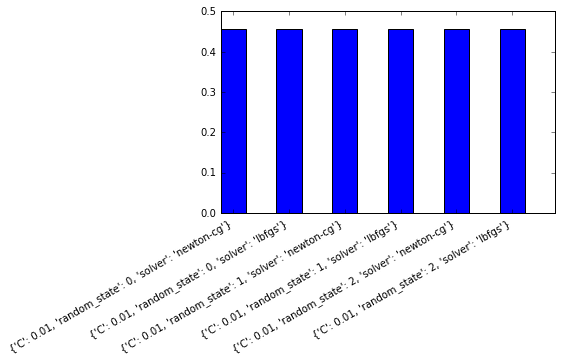

In [69]:
#Decision Tree tuning results show the best score and the best parameters
#Unfortunately If ipython kernel restarts, the graph will be lost.

Best score: 0.453253143794
Parameters : 
  max_depth: 13
  max_features: 'auto'
  random_state: 28


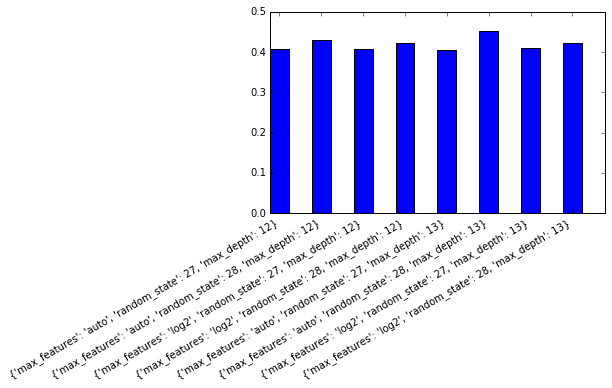

<b>3.</b>Classifying the data and evaluating the accuracy and other scores

        After, I had classified the development data with the best classifier so far, I observed that we can increase the accuracy by adding more valuable features to the training, for example if the tweet contains words which are in our lexicon's positive words or negative words, we can leverage from this. 
        
<b>4.</b>Implementing lexicons and evaluating them to find the best lexicon

        As specified in the assignment document, I implemented three lexicons and copied one manually annotated lexicon [-naming them as lexicons might be wrong, but I wanted to connect the terms with the specification document-] and created lists of positive and negative words from them. One of the lexicons was relatively very successful of finding positive and negative lists, which was sentiword_net. 

In [66]:
# cosine similarity accuracy   : 0.476216511755

# ppmi accuracy              : 0.358119190815

# sentiword_net accuracy    :  0.835975943138 

<b>5.</b> Error analysing and finding patterns in the data, Improvements on preprocessing
    
        After retraining the classifier, I filtered the errors and analysed them to find some patterns in order to fix and increase the performance, accuracy etc. Most of my strategies were on preprocessing step, because I thought if I create new better features and remove inefficient ones from the model, the weight of the efficient features in the model will increase and this will create a better model. For example, I thought if I remove numbers from the tweets, which are intuitively not effective to polarity, that will result into increase of the weights of the other features. Other examples were removing some of the punctuations, applying max_match algorithm, lemmatization etc. However, after I had tested the model, I observed that those differences made very little improvement (actually some of them made it worse). Since, I quickly ran out of time, I wasn't able to try other things to increase accuracy. However, I will discuss these in the following section. 
        The graphs below show the classifer's accuracy and other values after applying some improvements.

In [67]:
#Logistic regression after adding polarity data
# Accuracy = 0.513395297977
#              precision    recall  f1-score   support

#          -1       0.42      0.28      0.33       360
#           0       0.46      0.68      0.55       700
#           1       0.66      0.47      0.55       769

# avg / total       0.53      0.51      0.51      1829

In [ ]:
#Logistic regression after adding only cosine distance polarity data and applying improved preprocessing
# Accuracy = 0.515582285402
#              precision    recall  f1-score   support

#          -1       0.46      0.14      0.22       360
#           0       0.45      0.74      0.56       700
#           1       0.66      0.48      0.56       769

# avg / total       0.54      0.52      0.49      1829

<b>6.</b> Final testing

            I tested the test data on the best Logistic regression classifier by retraining it with the preprocessing improvements. I added only the cosine similarity lexicon(word2vec)'s feature to the model. In the end, the result was very slightly increased. Final result is as below. More importantly presicion value has increased and that means the improvements on preprocessing resulted into creating more accurate results. However, if we look more carefully to the precision and recall values, those values have changed dramatically. For example, for positive: precision value increased while the recall remained stable. But, for negative: precision value decreased with the equal rate and recall increased dramatically. That may suggest us that the lexicon, that I developed and used in this model as a feauture(cosine similarity), has problems with negative polarity in itself.

In [68]:
#Logistic Regression on test set
# Accuracy = 0.520199225235
#              precision    recall  f1-score   support

#          -1       0.41      0.19      0.26       290
#           0       0.43      0.73      0.54       625
#           1       0.71      0.48      0.57       892

# avg / total       0.56      0.52      0.51      1807


<b>Consequently,</b> although I achieved a very little improvement on the classifier, it still has many problems. 
I think the most important strategy to achieve better results is to reduce the randomicity of features as much as possible in this model. Just like I mentioned above, the features which have no relation with polarity should be removed from the model.


The performance of the whole project is very reasonable, also it includes testing time

--- Total Exec. time : 440.164999962 seconds ---